In [13]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: d:\College\glaucoma-detection-project


In [14]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.feature import local_binary_pattern

In [15]:
REFUGE_RAW = os.path.join(PROJECT_ROOT, "data", "raw", "refuge")
REFUGE_PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed", "refuge")

FEATURE_OUT = os.path.join(PROJECT_ROOT, "outputs", "metrics")
os.makedirs(FEATURE_OUT, exist_ok=True)

In [ ]:
missing_count = 0
def load_image_and_mask(split, img_name):
    img_path = os.path.join(REFUGE_PROCESSED, split, img_name)

    # Handle possible mask naming differences
    mask_dir = os.path.join(REFUGE_RAW, split, "mask")

    base_name = os.path.splitext(img_name)[0]

    possible_masks = [
        base_name + ".png",
        base_name + ".jpg",
        base_name + "_mask.png",
        base_name + "_mask.jpg"
    ]

    mask_path = None
    for m in possible_masks:
        candidate = os.path.join(mask_dir, m)
        if os.path.exists(candidate):
            mask_path = candidate
            break

    if mask_path is None:
        return None, None

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        return None, None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, mask

In [17]:
def compute_cdr_features(mask):
    disc = (mask == 255).astype(np.uint8)
    cup = (mask == 128).astype(np.uint8)

    disc_area = np.sum(disc)
    cup_area = np.sum(cup)

    cdr = cup_area / (disc_area + 1e-6)

    return disc_area, cup_area, cdr

In [18]:
def compute_color_features(img):
    mean_r = img[:, :, 0].mean()
    mean_g = img[:, :, 1].mean()
    mean_b = img[:, :, 2].mean()
    return mean_r, mean_g, mean_b

In [19]:
def compute_lbp_feature(img, radius=2, points=8):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, points, radius, method="uniform")
    return lbp.mean()

In [20]:
records = []

for split in ["training", "val", "testing"]:
    img_dir = os.path.join(REFUGE_PROCESSED, split)

    for img_name in tqdm(os.listdir(img_dir), desc=f"Extracting {split}"):
        img, mask = load_image_and_mask(split, img_name)
        if img is None:
            continue

        disc_area, cup_area, cdr = compute_cdr_features(mask)
        mean_r, mean_g, mean_b = compute_color_features(img)
        lbp_mean = compute_lbp_feature(img)

        # REFUGE labels:
        # glaucoma = 1, normal = 0
        label = 1 if "g" in img_name.lower() else 0  # fallback
        # (Later we can load official labels if needed)

        records.append({
            "image": img_name,
            "split": split,
            "disc_area": disc_area,
            "cup_area": cup_area,
            "cdr": cdr,
            "mean_r": mean_r,
            "mean_g": mean_g,
            "mean_b": mean_b,
            "lbp_mean": lbp_mean,
            "label": label
        })

Extracting testing: 100%|██████████| 400/400 [00:00<00:00, 39457.23it/s]


In [21]:
df_features = pd.DataFrame(records)
df_features.head()

,image,split,disc_area,cup_area,cdr,mean_r,mean_g,mean_b,lbp_mean,label
0,V0001.jpg,val,3709448,37525,0.010116,55.701212,20.607043,1.643555,5.966956,1
1,V0002.jpg,val,3708751,29953,0.008076,89.432079,43.080796,12.422154,5.684670,1
2,V0003.jpg,val,3713381,33628,0.009056,67.672991,40.985112,12.175044,6.009726,1
3,V0004.jpg,val,3684569,33935,0.009210,118.729512,55.658462,12.119260,5.742865,1
4,V0005.jpg,val,3718510,27677,0.007443,58.770309,29.351283,4.741032,5.912189,1


In [22]:
csv_path = os.path.join(FEATURE_OUT, "features_refuge.csv")
df_features.to_csv(csv_path, index=False)

print("Saved:", csv_path)

Saved: d:\College\glaucoma-detection-project\outputs\metrics\features_refuge.csv


In [23]:
df_features.describe()

,disc_area,cup_area,cdr,mean_r,mean_g,mean_b,lbp_mean,label
count,4.000000e+02,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.0
mean,3.706383e+06,43556.880000,0.011758,106.368414,53.023855,15.248893,5.750953,1.0
std,1.183820e+04,9205.775834,0.002512,18.417472,11.305065,8.808261,0.079840,0.0
min,3.663345e+06,12567.000000,0.003381,55.701212,20.546158,1.643555,5.442742,1.0
25%,3.697828e+06,37467.750000,0.010083,92.920869,44.953703,8.461884,5.703763,1.0
50%,3.707097e+06,43642.500000,0.011786,105.741311,51.600028,13.734973,5.759676,1.0
75%,3.715627e+06,49275.250000,0.013313,119.405114,60.565923,20.470658,5.807303,1.0
max,3.741733e+06,73151.000000,0.019844,152.887755,88.747230,48.587432,6.009726,1.0


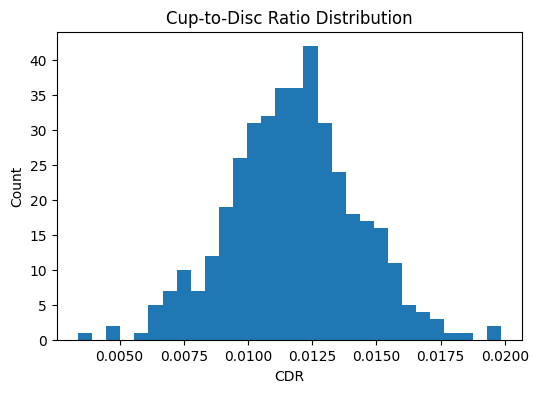

In [24]:
plt.figure(figsize=(6,4))
plt.hist(df_features["cdr"], bins=30)
plt.title("Cup-to-Disc Ratio Distribution")
plt.xlabel("CDR")
plt.ylabel("Count")
plt.show()

In [ ]:
from src.feature_engineering import extract_features_refuge

df_features = extract_features_refuge(
    processed_root="data/processed/refuge",
    raw_root="data/raw/refuge"
)

df_features.to_csv("outputs/metrics/features_refuge.csv", index=False)

df_features.head()